# Technical indicator classes
In order to use lots of indicators in one strategy, we have to make a class that handles calculations for each technical indicator. That will make the code simpler.

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#plt.style.use("seaborn")
#import sys

In [2]:
#load raw data 
raw = None
def load_data():
    global raw
    start = "2022-01-31"
    end = "2023-06-30"
    raw = pd.read_csv("data/5m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
    raw = raw.loc[start:end]
    raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
    raw["returns"] = np.log(raw.price / raw.price.shift(1))
    raw    

In [3]:
#Simple Moving Average
load_data() #resets data
class SMA():
    
    def __init__(self, data, SMA_S, SMA_L, column):
        self.data = data # Dataframe
        self.SMA_S = column + "|SMA|" + str(SMA_S) # short SMA
        self.SMA_L = column + "|SMA|" + str(SMA_L) # long SMA
        self.short = SMA_S
        self.long = SMA_L
        self.column = column # column to use SMA
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.SMA_S in self.data.columns or force:
            self.data[self.SMA_S] = self.data[self.column].rolling(self.short).mean()  
        if not self.SMA_L in self.data.columns or force:    
            self.data[self.SMA_L] = self.data[self.column].rolling(self.long).mean()
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    
    def calculate_for_last_row(self): #calculate just for last row
        self.data.loc[self.data.index[-1],self.SMA_S] = self.data[self.column].iloc[-self.short:].rolling(self.short).mean()[-1]
        self.data.loc[self.data.index[-1],self.SMA_L] = self.data[self.column].iloc[-self.long:].rolling(self.long).mean()[-1]
    
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.SMA_S][row] > self.data[self.SMA_L][row]: # signal to go long
            return 1
        elif self.data[self.SMA_S][row] < self.data[self.SMA_L][row]: # signal to go short
            return -1
        else:
            return 0
sma = SMA(
        data = raw,
        SMA_S = 50,
        SMA_L = 200,
        column = "price"
         )
sma.calculate() #calculate for all dataframe
sma.calculate_for_last_row() #calculate just for last row
raw #notice that original dataframe is changed

,price,returns,price|SMA|50,price|SMA|200
Date,,,,
2022-07-12 11:15:00,19729.8,NaN,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN,NaN
...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,24324.026,24250.9185
2022-08-16 04:15:00,24450.0,-0.004082,24327.712,24250.4185
2022-08-16 04:20:00,24508.3,0.002382,24335.530,24251.9000


In [38]:
#Exponentially Weighted Moving Average
load_data() #resets data
class EWMA():
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
    #approx average periods n are calculated by: n is approx 1/(1 - alpha)
    # => we are going to calculate alpha given n approx average periods as: alpha = 1- 1/n
    #Important: approx_avg_period are float in (1, inf). In (1,2) considers high weights for current day
    def __init__(self, data, approx_avg_period_s, approx_avg_period_l, column):
        self.data = data # Dataframe
        self.approx_avg_period_s = approx_avg_period_s
        self.approx_avg_period_l = approx_avg_period_l
        self.alpha_s = 1-1/approx_avg_period_s #alpha for short EWMA
        self.alpha_l = 1-1/approx_avg_period_l #alpha for long EWMA
        self.column = column # column to use SMA
        self.EWMA_S = column + "|EWMA|" + str(approx_avg_period_s) # short SMA
        self.EWMA_L = column + "|EWMA|" + str(approx_avg_period_l) # long SMA
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.EWMA_S in self.data.columns or force:
            self.data[self.EWMA_S] = self.data[self.column].ewm(alpha = self.alpha_s).mean()
        if not self.EWMA_L in self.data.columns or force:
            self.data[self.EWMA_L] = self.data[self.column].ewm(alpha = self.alpha_l).mean()
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        s = round(self.approx_avg_period_s)
        l = round(self.approx_avg_period_l)
        # precision. EWMA with more info gives more approx results as "calculate". recommend p = 2
        # for small s, needs more precision.
        p_s = max([100, s*2]) # min 100 of precision
        p_l = max([100, l*2]) # min 100 of precision
        #calculate EWMA and just update last row
        self.data.loc[self.data.index[-1],self.EWMA_S] = self.data[self.column][-p_s:].ewm(alpha = self.alpha_s).mean()[-1]
        self.data.loc[self.data.index[-1],self.EWMA_L] = self.data[self.column][-p_l:].ewm(alpha = self.alpha_l).mean()[-1]
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.EWMA_S][row] > self.data[self.EWMA_L][row]: # signal to go long
            return 1
        elif self.data[self.EWMA_S][row] < self.data[self.EWMA_L][row]: # signal to go short
            return -1
        else:
            return 0
        
ewma = EWMA(
        data = raw,
        approx_avg_period_s = 1.43546789,
        approx_avg_period_l = 99,
        column = "price"
         )
ewma.calculate() #calculate for all dataframe
ewma.calculate_for_last_row() #calculate just for last row
#print(ewma.strategy1(-1)) #print strategy for last row
raw #notice that original dataframe is changed

,price,returns,price|EWMA|1.43546789,price|EWMA|99
Date,,,,
2022-07-12 11:15:00,19729.8,NaN,19729.800000,19729.800000
2022-07-12 11:20:00,19713.8,-0.000811,19720.369580,19713.960000
2022-07-12 11:25:00,19772.7,0.002983,19744.353016,19772.106727
2022-07-12 11:30:00,19823.3,0.002556,19775.680935,19822.782897
2022-07-12 11:35:00,19766.9,-0.002849,19772.494286,19767.464474
...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,24500.496954,24549.491742
2022-08-16 04:15:00,24450.0,-0.004082,24485.178045,24451.004967
2022-08-16 04:20:00,24508.3,0.002382,24492.192391,24507.721262


In [46]:
#Exponentially Weighted Moving Average
load_data() #resets data
class BollingerBands():
    
    def __init__(self, data, column = "price", dev = 1, periods = 50):
        self.data = data # Dataframe
        self.column = column #column used to calculate BBs
        self.dev = dev #standard deviations for BBs
        self.BBS = column + "|BBs|" + str(dev)+"|"+str(periods) #Name of BBS
        self.SMA = column + "|SMA|" + str(periods) #SMA FOR BBs
        self.last_position = 0 #saves last position
        self.periods = periods
    def calculate(self, force = False): #calculate for all dataframe
        if not self.BBS+"|Distance" in self.data.columns or force:
            SM = self.data[self.column].rolling(self.periods) #SMA one step before calculating mean()
            if not self.SMA in self.data.columns or force: self.data[self.SMA] = SM.mean()
            self.data[self.BBS+"|Lower"] = self.data[self.SMA] - SM.std() * self.dev
            self.data[self.BBS+"|Upper"] = self.data[self.SMA] + SM.std() * self.dev
            self.data[self.BBS+"|Distance"] = self.data[self.column] - self.data[self.SMA] 
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        SM = self.data[self.column][-self.periods:].rolling(self.periods)
        self.data.loc[self.data.index[-1],self.SMA] = SM.mean()[-1]
        self.data.loc[self.data.index[-1],self.BBS + "|Lower"] = self.data[self.SMA][-1] - SM.std()[-1] * self.dev
        self.data.loc[self.data.index[-1],self.BBS + "|Upper"] = self.data[self.SMA][-1] + SM.std()[-1] * self.dev
        self.data.loc[self.data.index[-1],self.BBS + "|Distance"] = self.data[self.column][-1] - self.data[self.SMA][-1] 
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        ### How to evaluate vectorized strategy ###
        #self.data["position"] = np.where(self.data[self.column] < self.data.Lower, 1, np.nan)
        #self.data["position"] = np.where(self.data[self.column] > self.data.Upper, -1, self.data["position"])
        #self.data["position"] = np.where(self.data.distance * self.data.distance.shift(1) < 0, 0, self.data["position"])
        #self.data["position"] = self.data.position.ffill().fillna(0) 
                
        if self.data[self.column][row] < self.data[self.BBS+"|Lower"][row]:
            self.last_position = 1
        elif self.data[self.column][row] > self.data[self.BBS+"|Upper"][row]:
            self.last_position = -1 
        elif row != 0 and self.data[self.BBS+"|Distance"][row] * self.data[self.BBS+"|Distance"][row-1] < 0:
            self.last_position = 0
        return self.last_position
        
        
bbs = BollingerBands(
        data = raw,
        dev = 1, 
        periods = 50,
        column = "price"
         )
bbs.calculate() #calculate for all dataframe
bbs.calculate_for_last_row() #calculate just for last row
#print(bbs.strategy1(-1)) #print strategy for last row
raw #notice that original dataframe is changed

,price,returns,price|SMA|50,price|SMA|200,price|BBs|1|50|Lower,price|BBs|1|50|Upper,price|BBs|1|50|Distance
Date,,,,,,,
2022-07-12 11:15:00,19729.8,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN,NaN,NaN,NaN,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN,NaN,NaN,NaN,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN,NaN,NaN,NaN,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,24324.026,24250.9185,24141.569419,24506.482581,225.974
2022-08-16 04:15:00,24450.0,-0.004082,24327.712,24250.4185,24144.597338,24510.826662,122.288
2022-08-16 04:20:00,24508.3,0.002382,24335.530,24251.9000,24153.234947,24517.825053,172.770


<AxesSubplot:xlabel='Date'>

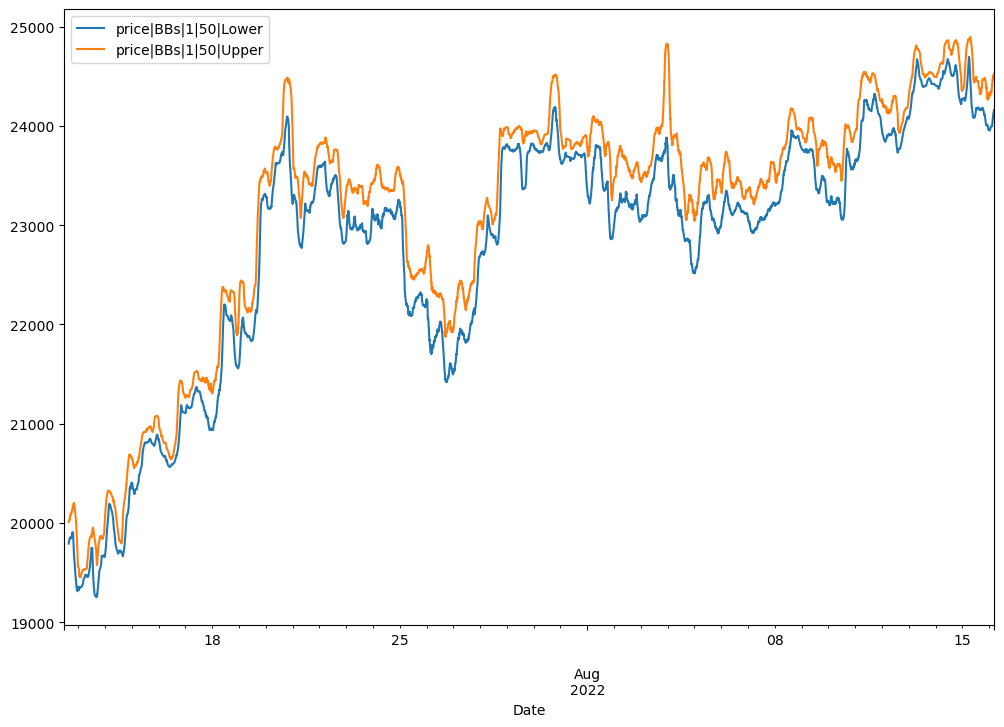

In [14]:
raw[["price|BBs|1|50|Lower", "price|BBs|1|50|Upper"]].plot(figsize = (12, 8))

24450.0